In [1]:
import os
import sys
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Soc 225\\Soc-225\\Final Project'

In [2]:
# importing libraries & making torch.device object for GPU

# neural network packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

# data packages
import h5py
import numpy as np

# visual packages
import matplotlib.pyplot as plt
%matplotlib inline

#other
from functions import experiment, SignalDataset
from model import SignalClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print('loading training data', end='\r')
hdf = h5py.File('../../Data/CCSN_Pan_SNR_Free.h5', 'r')

signals = {
    'NR': hdf['Model_NR']['Hp'], # NR: No Rotation
    'SR': hdf['Model_SR']['Hp'], # SR: Slow Rotation
    'FR': hdf['Model_FR']['Hp'], # FR: Fast Rotation
    'Noise': hdf['Noise']['Strain']
}

# Create datasets
print('creating training datasets', end='\r')
nr_dataset = SignalDataset(signals, 'NR')
sr_dataset = SignalDataset(signals, 'SR')
fr_dataset = SignalDataset(signals, 'FR')
noise_dataset = SignalDataset(signals, 'Noise')

# Combine datasets
print('combining training datasets', end='\r')
full_dataset = ConcatDataset([nr_dataset, sr_dataset, fr_dataset, noise_dataset])

# Create training dataloader
print('creating train DataLoader', end='\r')
batch_size = 64
train_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

In [4]:
print('loading test data', end='\r')
hdf_test = h5py.File('../../Data/GW1_CCSN_Pan_SNR_Free_Test_Validation.h5', 'r')

test_signals = {
    'NR': hdf_test['Model_NR']['Hp'], # NR: No Rotation
    'SR': hdf_test['Model_SR']['Hp'], # SR: Slow Rotation
    'FR': hdf_test['Model_FR']['Hp'], # FR: Fast Rotation
    'Noise': hdf_test['Noise']['Strain']
}

print('creating test datasets', end='\r')
nr_test_dataset = SignalDataset(test_signals, 'NR')
sr_test_dataset = SignalDataset(test_signals, 'SR')
fr_test_dataset = SignalDataset(test_signals, 'FR')
noise_test_dataset = SignalDataset(test_signals, 'Noise')

print('combining test datasets', end='\r')
test_dataset = ConcatDataset([nr_test_dataset, sr_test_dataset, fr_test_dataset, noise_test_dataset])

print('creating test DataLoader', end='\r')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

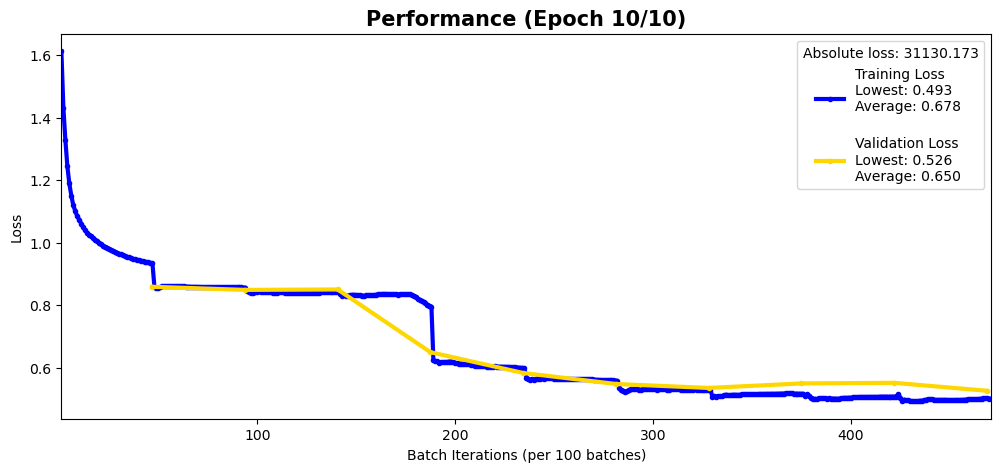

31130.172979936004

<Figure size 640x480 with 0 Axes>

In [5]:
model = SignalClassifier(
    input_size=8192,
    in_channels=1, 
    hidden_channels=32, 
    out_channels=64, 
    conv_kernel_size=5, 
    pool_kernel_size=2, 
    pool_stride=2, 
    dropout=0.5, 
    leak=0.4
).to(device)
experiment = experiment(model, train_loader, test_loader, batch_size);

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print('training model', end='\r')
experiment.train(optimizer, loss_function, epochs=10)

Test Loss: 0.5269, Test Accuracy: 0.8266


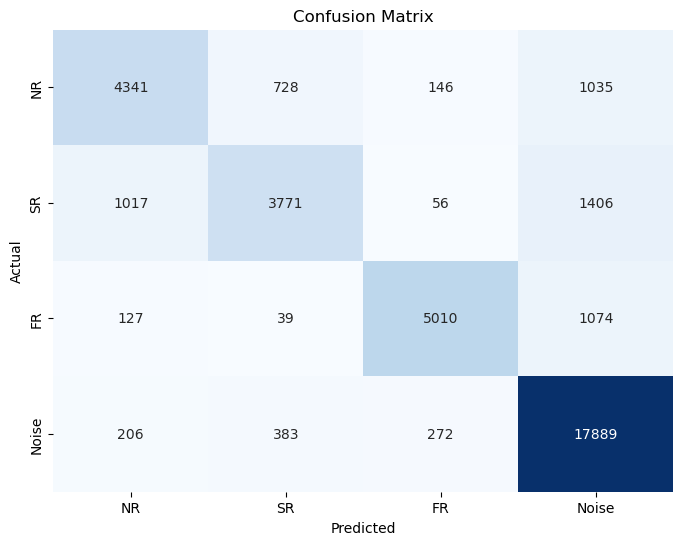

In [6]:
experiment.evaluate()
experiment.confusion_matrix()